##prep

In [ ]:
!pip install matplotlib==3.4.2

In [ ]:
import numpy as np
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1FGPFuPhDm7TP4ldlONogjAUtoskOay1J"})
downloaded.GetContentFile('train.csv') 
train = pd.read_csv('train.csv') 
downloaded = drive.CreateFile({'id':"1hB6XLrMXVgyFIjZ-tpS2x0u0aegIh5rY"})
downloaded.GetContentFile('val.csv') 
val = pd.read_csv('val.csv') 
downloaded = drive.CreateFile({'id':"1ZDTPRJjZgOdkFOngjuN7RKd8-PMWCTnx"})
downloaded.GetContentFile('test.csv') 
test = pd.read_csv('test.csv') 

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

X_train = train['review']
y_train = train['condition']
X_validation = val['review']
y_validation = val['condition']
X_test = test['review']
y_test = test['condition']

from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvec = TfidfVectorizer(ngram_range=(1,1))
x_train = tfidfvec.fit_transform(X_train)
x_train

<694x3392 sparse matrix of type '<class 'numpy.float64'>'
	with 21716 stored elements in Compressed Sparse Row format>

In [ ]:
x_train.todense().shape[1]

3392

In [ ]:
features_taken = x_train.todense().shape[1]
features_taken

3392

##Baseline

In [ ]:
text_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,1),max_features=features_taken)), ('clf', SVC())])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)

In [ ]:
text_clf

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=3392,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', deg

In [ ]:
from sklearn.metrics import accuracy_score
baseline_acc = accuracy_score(y_test, predicted)
baseline_acc

0.910958904109589

##Start Tuning

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvec = TfidfVectorizer(ngram_range=(1,1),max_features=features_taken)
X_train = tfidfvec.fit_transform(X_train)
X_train

<694x3392 sparse matrix of type '<class 'numpy.float64'>'
	with 21716 stored elements in Compressed Sparse Row format>

In [ ]:
X_test = tfidfvec.transform(X_test)
X_test

<438x3392 sparse matrix of type '<class 'numpy.float64'>'
	with 12474 stored elements in Compressed Sparse Row format>

###Setting params

In [ ]:
C = [0.001,0.01,0.1,1,10,100,1000]
gamma = ['scale','auto']

###linear kernel

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

param_grid = {'C': C, 
              'kernel': ['linear']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=10, refit=True)
  
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred_test = grid.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(f1_score(y_test, y_pred_test))
linear_acc = accuracy_score(y_test, y_pred_test)
print(linear_acc)

{'C': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       219
           1       0.91      0.90      0.91       219

    accuracy                           0.91       438
   macro avg       0.91      0.91      0.91       438
weighted avg       0.91      0.91      0.91       438

0.9057471264367817
0.906392694063927


###rbf kernel

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': C, 
              'gamma': gamma,
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=10, refit=True)
  
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred_test = grid.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(f1_score(y_test, y_pred_test))
rbf_acc = accuracy_score(y_test, y_pred_test)
print(rbf_acc)

{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       219
           1       0.95      0.88      0.91       219

    accuracy                           0.91       438
   macro avg       0.92      0.91      0.91       438
weighted avg       0.92      0.91      0.91       438

0.909952606635071
0.91324200913242


###poly kernel

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': C, 
              'gamma': gamma,
              'kernel': ['poly'],
              'degree': [2,3,4,5]} 
  
grid = GridSearchCV(SVC(), param_grid, cv=10, refit=True)
  
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred_test = grid.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(f1_score(y_test, y_pred_test))
poly_acc = accuracy_score(y_test, y_pred_test)
print(poly_acc)

{'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       219
           1       0.93      0.89      0.91       219

    accuracy                           0.91       438
   macro avg       0.91      0.91      0.91       438
weighted avg       0.91      0.91      0.91       438

0.9086651053864168
0.910958904109589


##Plotting

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker
xlabels = ['linear', 'rbf', 'poly'] # masukin list kernel nya yang di pake apa aja
ylabels = np.arange(start=0, stop=1, step=0.01)

baseline_acc = round(baseline_acc,3)
linear_acc = round(linear_acc,3)
rbf_acc = round(rbf_acc,3)
poly_acc = round(poly_acc,3)
akurasi_1 = [baseline_acc,baseline_acc,baseline_acc] # akurasi  di urutin sama list kernel
akurasi_2 = [linear_acc, rbf_acc, poly_acc] # akurasi di urutin sama list kernel
selisih = [(linear_acc-baseline_acc),(rbf_acc-baseline_acc),(poly_acc-baseline_acc)]


x = np.arange(len(xlabels))  # yang ini ga usah di ubah
width = 0.2  # lebar bar

fig, ax = plt.subplots(figsize=(10,8))
plt.gcf().set_dpi(1000)
rects2 = ax.bar(x - 0.21, akurasi_1, width, label='Untuned Accuracy', color='b')
rects3 = ax.bar(x + 0.0, akurasi_2, width, label='Tuned Accuracy', color='g')
rects4 = ax.bar(x + 0.21, selisih, width, label='Difference', color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(xlabels, fontsize=12)
plt.yticks(fontsize=12)
ax.legend(fontsize=12, loc=6)

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.bar_label(rects2, padding=5, fontsize=11)
ax.bar_label(rects3, padding=5, fontsize=11)
ax.bar_label(rects4, padding=5, fontsize=11)

plt.show()

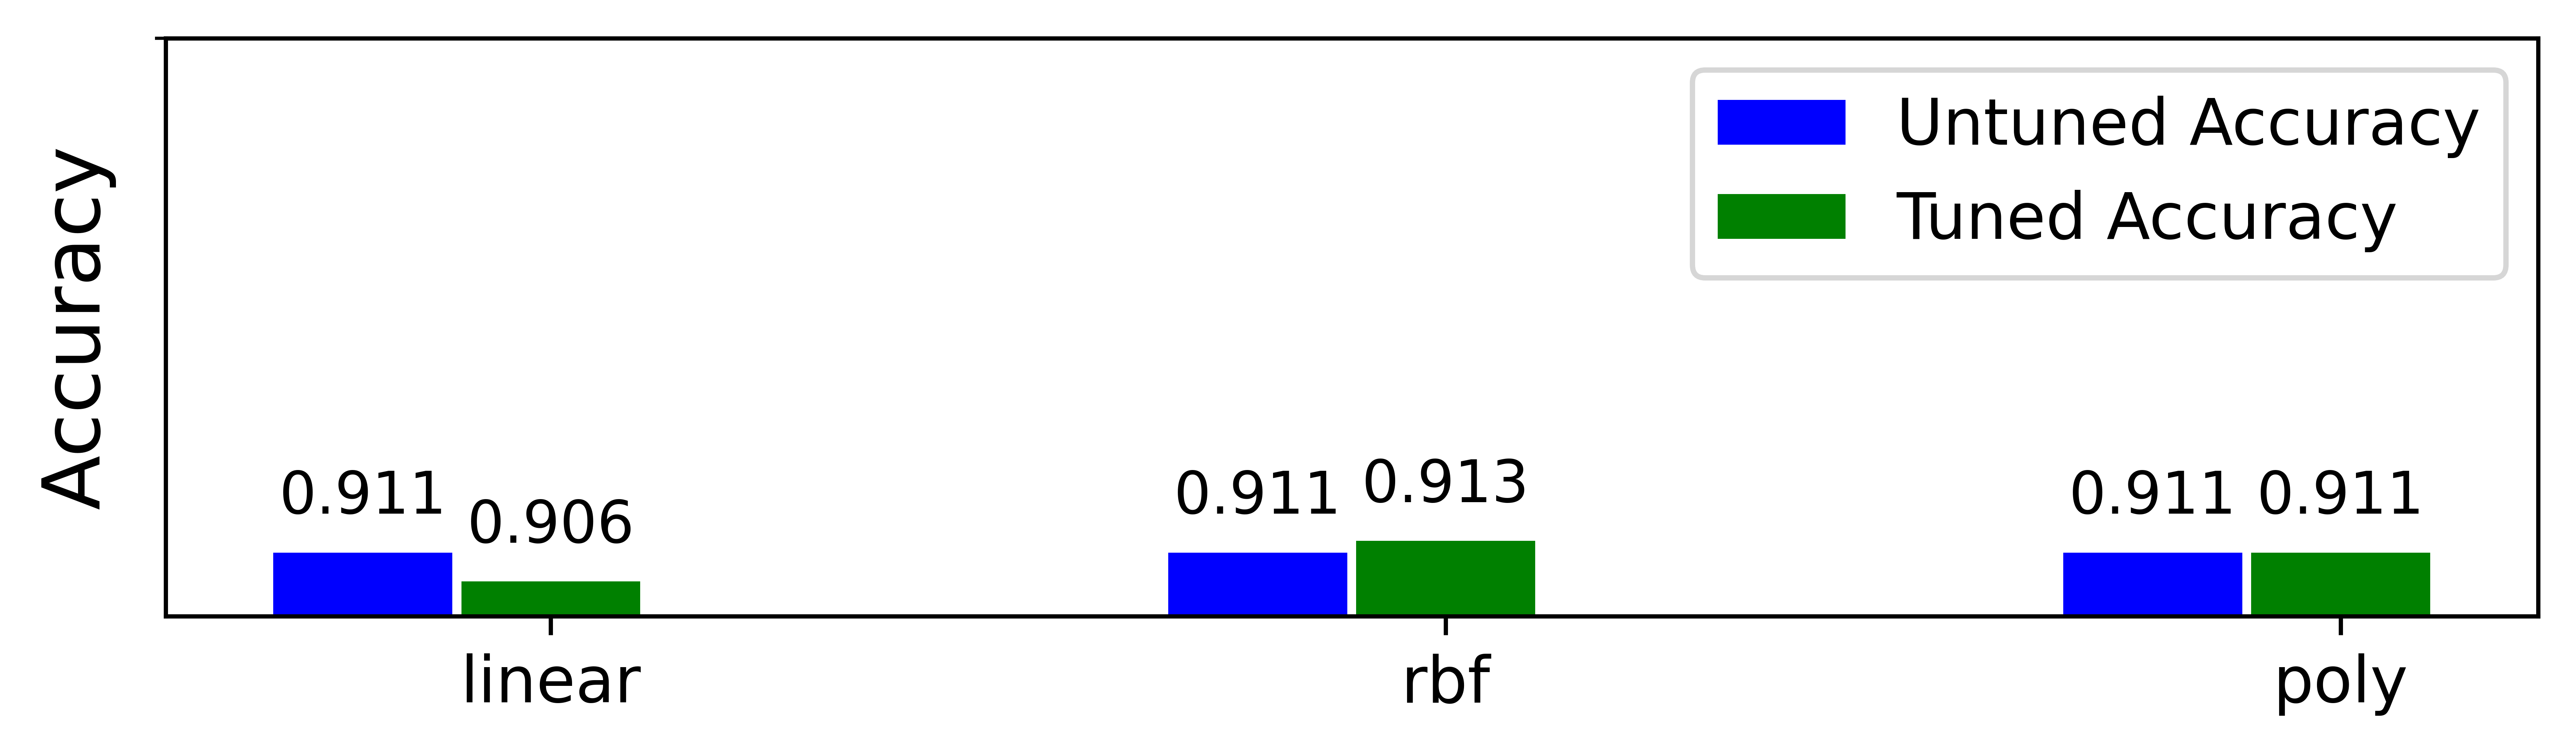

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker
xlabels = ['linear', 'rbf', 'poly'] # masukin list kernel nya yang di pake apa aja
ylabels = np.arange(start=0.9, stop=1, step=0.01)

baseline_acc = round(baseline_acc,3)
linear_acc = round(linear_acc,3)
rbf_acc = round(rbf_acc,3)
poly_acc = round(poly_acc,3)
akurasi_1 = [baseline_acc,baseline_acc,baseline_acc] # akurasi  di urutin sama list kernel
akurasi_2 = [linear_acc, rbf_acc, poly_acc] # akurasi di urutin sama list kernel


x = np.arange(len(xlabels))  # yang ini ga usah di ubah
width = 0.2  # lebar bar

fig, ax = plt.subplots(figsize=(8,2))
plt.gcf().set_dpi(1000)
rects2 = ax.bar(x - 0.21, akurasi_1, width, label='Untuned Accuracy', color='b')
rects3 = ax.bar(x + 0.0, akurasi_2, width, label='Tuned Accuracy', color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(xlabels, fontsize=12)
plt.yticks(fontsize=12)
ax.legend(fontsize=12, loc=0)

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.bar_label(rects2, padding=5, fontsize=11)
ax.bar_label(rects3, padding=5, fontsize=11)

plt.ylim(0.9, 1)
plt.show()